In [1]:
# Import Libraries
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import json
import panel as pn
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
pn.extension('plotly')
import plotly.express as px
import seaborn as sns
import nltk

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\jesus\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Dogecoin Price from CSV
doge_data_df = pd.read_csv('Plots/DOGE-USD.csv')
doge_price_df = doge_data_df.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
doge_price_df.rename(columns={"Close":"Doge Price"}, inplace=True)
doge_price_df.set_index('Date', inplace=True)
# doge_price_df

## Doge Data Table Debugging

In [3]:
doge_price_df.tail()

,Doge Price
Date,
2021-05-06,0.580804
2021-05-07,0.684777
2021-05-08,0.636439
2021-05-09,0.570070
2021-05-10,0.508892


In [4]:
# Daily change in price column
doge_daily_price_pct_change = doge_price_df.pct_change(1)
doge_daily_price_pct_change.columns = ['Doge Daily Price Change %']
doge_daily_price_pct_change = doge_daily_price_pct_change.dropna()
doge_daily_price_pct_change.tail()

,Doge Daily Price Change %
Date,
2021-05-06,-0.116827
2021-05-07,0.179016
2021-05-08,-0.070589
2021-05-09,-0.104282
2021-05-10,-0.107317


In [5]:
# Define all the different data frames into a list
doge_frames = [doge_price_df, doge_daily_price_pct_change]

# Concatenate all the dataframes into one
doge_data = pd.concat(doge_frames, axis=1, join="outer", ignore_index=False)
doge_data['Doge Daily Price Change %'] = doge_data['Doge Daily Price Change %']*100
doge_data.reset_index(inplace=True)
doge_data.columns = ['Date', 'Doge Price', 'Doge Daily Price Change %']
doge_data['Date'] = pd.to_datetime(doge_data['Date'])
doge_data.set_index('Date', inplace=True)
doge_data.tail()

,Doge Price,Doge Daily Price Change %
Date,,
2021-05-06,0.580804,-11.682656
2021-05-07,0.684777,17.901564
2021-05-08,0.636439,-7.058940
2021-05-09,0.570070,-10.428179
2021-05-10,0.508892,-10.731665


## Get news

In [6]:
#Dogecoin news from CSV
dogecoin_df = pd.read_csv(Path('Plots/DataNews_Dogecoin.csv'))
dogecoin_df['Published Date'] = pd.to_datetime(dogecoin_df['Published Date'], exact = False, infer_datetime_format=True, format = '%Y/%m%d')
for i in dogecoin_df.index:
     dogecoin_df['Published Date'][i] = dogecoin_df['Published Date'][i].date()
dogecoin_df.columns = ['Date', 'Title', 'Content']

# Dogecoin Analysis

## VADER Sentiment Analysis

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# Create function to store the sentiment scores in DataFrame
doge_sentiments = []


for i in dogecoin_df.index:
    try:
        text = dogecoin_df["Content"][i]
        date = dogecoin_df["Date"][i]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
    
        
        doge_sentiments.append({
            "text": text,
            "Date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
        })
        
    except AttributeError:
        pass

    
    
# Create DataFrame
doge_df = pd.DataFrame(doge_sentiments)

# Reorder DataFrame columns
cols = ["Date", "text", "compound", "positive", "negative", "neutral"]
doge_df = doge_df[cols]

doge_df.head()

,Date,text,compound,positive,negative,neutral
0,2017-09-15,"Jackson Palmer, creator of Dogecoin, in San Fr...",-0.6059,0.098,0.169,0.733
1,2017-11-08,The controversial SegWit2x fork has been suspe...,-0.7351,0.000,0.163,0.837
2,2018-01-25,Messaging app Telegram started out as a WhatsA...,-0.5023,0.000,0.083,0.917
3,2018-10-20,The startup is behind the Emma app for iOS and...,0.5859,0.148,0.047,0.805
4,2019-04-25,By CCN: As bitcoin’s price experienced a surge...,0.8070,0.175,0.000,0.825


In [9]:
# Get descriptive stats from the DataFrame
doge_df.describe()

,compound,positive,negative,neutral
count,1320.000000,1320.000000,1320.000000,1320.000000
mean,0.263925,0.079610,0.027657,0.892736
std,0.417506,0.070063,0.044600,0.078820
min,-0.888500,0.000000,0.000000,0.563000
25%,0.000000,0.000000,0.000000,0.842000
50%,0.327500,0.065000,0.000000,0.901000
75%,0.612400,0.121000,0.048000,0.949000
max,0.979600,0.437000,0.262000,1.000000


In [10]:
# set Date column to index
doge_df['Date'] = pd.to_datetime(doge_df['Date'])
doge_df = doge_df.set_index('Date')

In [11]:
doge_merged = pd.merge(
    doge_df,
    doge_data,
    how='inner',
    on='Date')

doge_merged.dropna()
doge_merged.tail(20)

,text,compound,positive,negative,neutral,Doge Price,Doge Daily Price Change %
Date,,,,,,,
2021-05-07,now Make the most of your money by signing up ...,0.0000,0.000,0.000,1.000,0.684777,17.901564
2021-05-07,now Make the most of your money by signing up ...,0.0000,0.000,0.000,1.000,0.684777,17.901564
2021-05-07,Dogecoin has made several attempts to settle b...,0.8658,0.195,0.000,0.805,0.684777,17.901564
2021-05-07,"WEST PALM BEACH, Fla. — Your social media feed...",0.5584,0.117,0.047,0.837,0.684777,17.901564
2021-05-07,Get daily crypto briefings and weekly Bitcoin ...,0.0000,0.115,0.094,0.791,0.684777,17.901564
2021-05-07,Dogecoin slid by 11.15% on Thursday. Reversing...,0.4215,0.072,0.034,0.894,0.684777,17.901564
2021-05-07,Falling short of the first major resistance le...,-0.2023,0.101,0.135,0.763,0.684777,17.901564
2021-05-07,Dogecoin surged by 22% on 5th May to record a ...,0.1901,0.036,0.000,0.964,0.684777,17.901564
2021-05-07,"WEST PALM BEACH, Fla. — Your social media feed...",0.5584,0.117,0.047,0.837,0.684777,17.901564


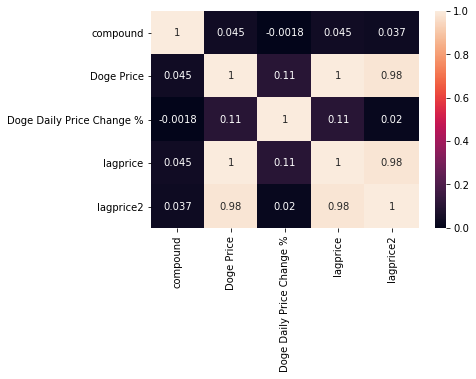

In [12]:
#set mulitple daily observations to a single mean
doge_viz_d = doge_merged.groupby(pd.Grouper(freq='d')).mean().dropna(how='all')
doge_viz_text = pd.DataFrame(doge_merged['text'].groupby('Date').apply(lambda texts: ' '.join(texts)))

doge_viz_w = doge_merged.groupby(pd.Grouper(freq='w')).mean().dropna(how='all')
doge_viz_m = doge_merged.groupby(pd.Grouper(freq='m')).mean().dropna(how='all')
doge_viz_y = doge_merged.groupby(pd.Grouper(freq='y')).mean().dropna(how='all')

doge_corr_d = doge_viz_d.drop(columns=['positive','negative','neutral'])
doge_corr_w = doge_viz_w.drop(columns=['positive','negative','neutral'])
doge_corr_m = doge_viz_m.drop(columns=['positive','negative','neutral'])
doge_corr_y = doge_viz_y.drop(columns=['positive','negative','neutral'])

doge_corr_d['lagprice'] = doge_corr_d['Doge Price'].shift(0)
doge_corr_d['lagprice2'] = doge_corr_d['Doge Price'].shift(1)

doge_corr_w['lagprice'] = doge_corr_w['Doge Price'].shift(0)
doge_corr_w['lagprice2'] = doge_corr_w['Doge Price'].shift(1)

doge_corr_m['lagprice'] = doge_corr_m['Doge Price'].shift(0)
doge_corr_m['lagprice2'] = doge_corr_m['Doge Price'].shift(1)

doge_corr_y['lagprice'] = doge_corr_y['Doge Price'].shift(0)
doge_corr_y['lagprice2'] = doge_corr_y['Doge Price'].shift(1)

doge_heat_d = sns.heatmap(doge_corr_d.corr(), annot = True)
doge_hfig_d = doge_heat_d.get_figure()
doge_hfig_d.savefig('Plots/doge_heat_d.png')

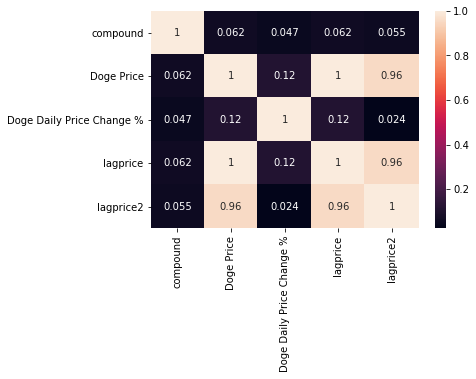

In [13]:
doge_heat_w = sns.heatmap(doge_corr_w.corr(), annot = True)
doge_hfig_w = doge_heat_w.get_figure()
doge_hfig_w.savefig('Plots/doge_heat_w.png')

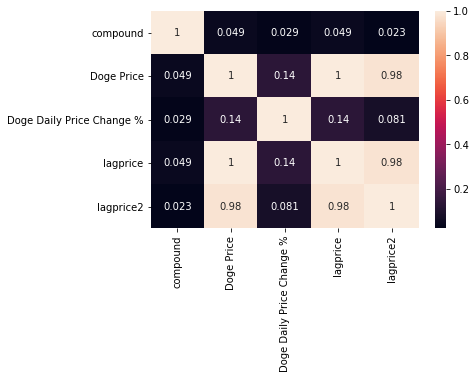

In [14]:
doge_heat_m = sns.heatmap(doge_corr_m.corr(), annot = True)
doge_hfig_m = doge_heat_m.get_figure()
doge_hfig_m.savefig('Plots/doge_heat_m.png')

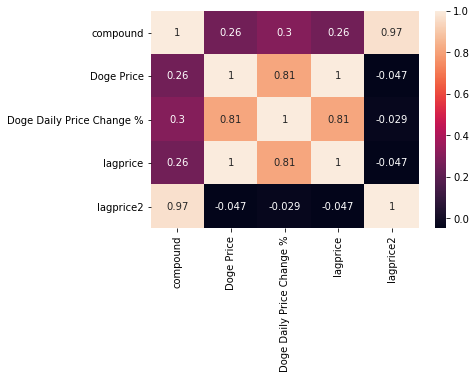

In [15]:
doge_heat_y = sns.heatmap(doge_corr_y.corr(), annot = True)
doge_hfig_y = doge_heat_y.get_figure()
doge_hfig_y.savefig('Plots/doge_heat_y.png')

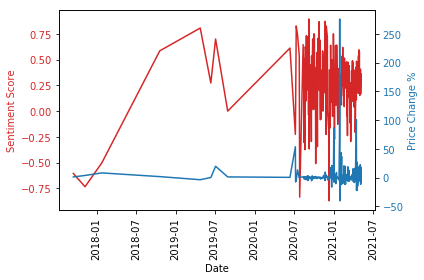

In [16]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color=color)
ax1.plot(doge_viz_d['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price Change %', color=color)  
ax2.plot(doge_viz_d['Doge Daily Price Change %'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

doge_lfig = ax2.get_figure()
doge_lfig.savefig('Plots/doge_lines_d.png')
plt.show()

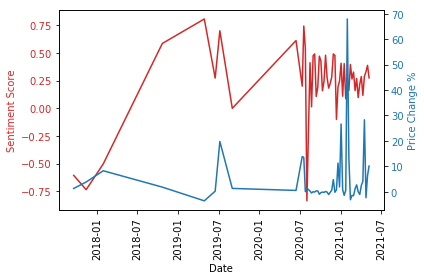

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color=color)
ax1.plot(doge_viz_w['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price Change %', color=color)  
ax2.plot(doge_viz_w['Doge Daily Price Change %'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

doge_lfig = ax2.get_figure()
doge_lfig.savefig('Plots/doge_lines_w.png')
plt.show()

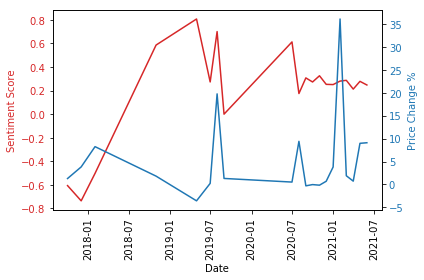

In [18]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color=color)
ax1.plot(doge_viz_m['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price Change %', color=color)  
ax2.plot(doge_viz_m['Doge Daily Price Change %'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

doge_lfig = ax2.get_figure()
doge_lfig.savefig('Plots/doge_lines_m.png')
plt.show()

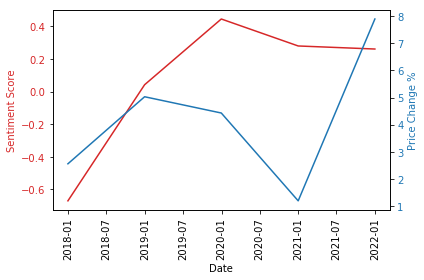

In [19]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color=color)
ax1.plot(doge_viz_y['compound'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 90)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Price Change %', color=color)  
ax2.plot(doge_viz_y['Doge Daily Price Change %'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

doge_lfig = ax2.get_figure()
doge_lfig.savefig('Plots/doge_lines_y.png')
plt.show()

## Build a predictive Model with Vader

In [20]:
# Add in a binary classifier for positive and negative price changes
doge_merged['target'] = np.where(doge_merged['Doge Daily Price Change %'] >= 0, 1, 0)

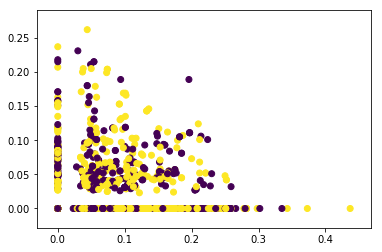

In [21]:
X = doge_merged["text"]
y = doge_merged["target"]

# Split data into train & test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

# Visualize the data
doge_scatter = plt.scatter(doge_merged['positive'],doge_merged['negative'], c=y)
doge_sfig = doge_scatter.get_figure()
doge_sfig.savefig('Plots/doge_scatter.png')

In [22]:
# Append sentiment back using indices
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [23]:
# Check dimensions
print(f"Train: {train.shape[0]} rows and {train.shape[1]} columns")
print(f"{train['target'].value_counts()}\n")
print(f"Test: {test.shape[0]} rows and {test.shape[1]} columns")
print(test['target'].value_counts())

Train: 742 rows and 2 columns
1    387
0    355
Name: target, dtype: int64

Test: 330 rows and 2 columns
1    184
0    146
Name: target, dtype: int64


In [24]:
train[['neg', 'neu', 'pos', 'compound']] = train['text'].apply(analyzer.polarity_scores).apply(pd.Series)
train.head()

,text,target,neg,neu,pos,compound
Date,,,,,,
2021-04-08,The online brokerage service Robinhood said on...,1,0.000,1.000,0.000,0.0000
2021-02-01,I am using AltCoinTrader...got no issues with ...,0,0.158,0.842,0.000,-0.5106
2021-04-25,"\n• Safemoon, a new digital token launched in ...",0,0.000,0.966,0.034,0.1280
2021-04-18,APRIL 18 — The last few weeks has seen me make...,1,0.000,0.832,0.168,0.8423
2021-03-28,(NYTIMES) – It did not look like a very promis...,0,0.044,0.801,0.155,0.6424


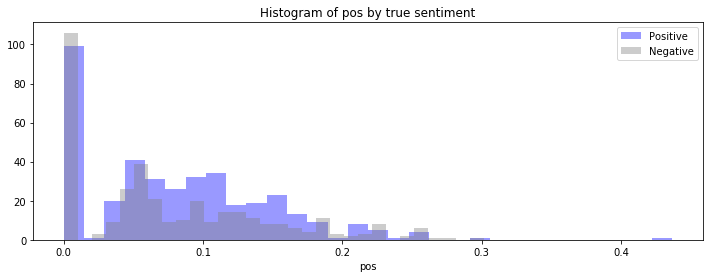

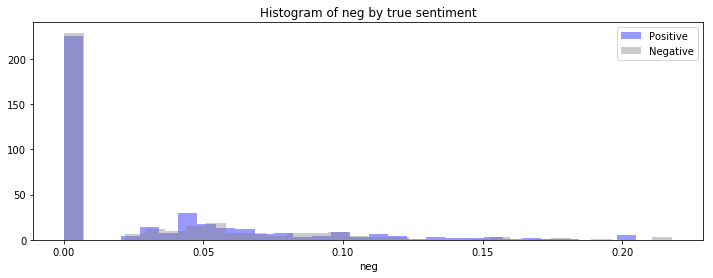

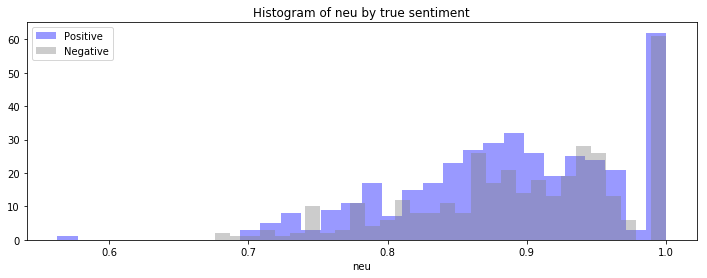

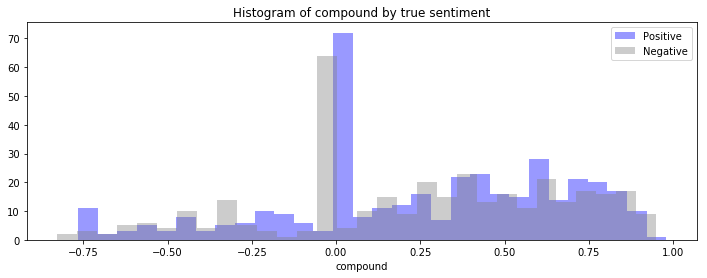

In [25]:
for var in ['pos', 'neg', 'neu', 'compound']:
    plt.figure(figsize=(12,4))
    sns.distplot(train.query("target==1")[var], bins=30, kde=False, 
                 color='blue', label='Positive')
    sns.distplot(train.query("target==0")[var], bins=30, kde=False, 
                 color='gray', label='Negative')
    plt.legend()
    plt.title(f'Histogram of {var} by true sentiment')
    plt.savefig("Plots/doge_"+str(var)+".png");

# Build a Predictive Model with RNN LSTM

In [26]:
# Import the Tokenizer method from Keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [27]:
# Create an instance of the Tokenizer and fit it with the X text data
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

In [28]:
# Print the first five elements of the encoded vocabulary
for token in list(tokenizer.word_index)[:10]:
    print(f"word: '{token}', token: {tokenizer.word_index[token]}")

word: 'the', token: 1
word: 'a', token: 2
word: 'of', token: 3
word: 'chars', token: 4
word: 'to', token: 5
word: 'and', token: 6
word: 'in', token: 7
word: 'dogecoin', token: 8
word: 'on', token: 9
word: 'is', token: 10


In [29]:
# Transform the text data to numerical sequences
X_seq = tokenizer.texts_to_sequences(X)

In [30]:
# Contrast a sample numerical sequence with its text version
print("**Text comment**")
print({X[0]})

**Text comment**
{'Jackson Palmer, creator of Dogecoin, in San Francisco on Friday. He was an early fan of cryptocurrency, but is now one of the loudest voices warning of a crash in the market.\n\nJackson Palmer no longer thinks it’s funny to imitate Doge, the internet m ... [+8465 chars]'}


In [31]:
print("**Numerical sequence representation**")
print(X_seq[0])

**Numerical sequence representation**
[448, 482, 511, 3, 8, 7, 886, 1523, 9, 291, 41, 20, 29, 253, 537, 3, 15, 56, 10, 39, 59, 3, 1, 2504, 3822, 3823, 3, 2, 1874, 7, 1, 27, 448, 482, 126, 1524, 1299, 192, 2505, 5, 3824, 26, 1, 260, 413, 3825, 4]


In [66]:
# Import the pad_sequences method from Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the pad size
max_words = 10000

# Pad the sequences using the pad_sequences() method
X_pad = pad_sequences(X_seq)
#                       , padding = 'post', truncating = 'post')
X_pad

array([[   0,    0,    0, ...,  413, 3825,    4],
       [   0,    0,    0, ..., 3833, 1875,    4],
       [   0,    0,    0, ...,  414, 3843,    4],
       ...,
       [   0,    0,    0, ..., 7405, 3279,    4],
       [   0,    0,    0, ...,  599, 3821,    4],
       [   0,    0,    0, ...,  599, 3821,    4]])

In [67]:
# Creating training, validation, and testing sets using the encoded data
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_pad, y)

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)

In [68]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler

# RandomOverSampler randomly duplicates minority class transactions
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_rnn, y_train_rnn)


In [69]:
len(y_test_rnn)

330

In [70]:
# Import Keras modules for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [71]:
# Model set-up
vocabulary_size = len(tokenizer.word_counts.keys()) + 1
embedding_size = 64

In [72]:
# Define the LSTM RNN model
model = Sequential()

# Layer 1
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Layer 2
model.add(LSTM(units=280))

# Output layer
model.add(Dense(units=1, activation="sigmoid"))

In [73]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.TruePositives(name="tp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
    ],
)

In [74]:
np.__version__

'1.19.5'

In [75]:
# Show model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10000, 64)         473984    
_________________________________________________________________
lstm_1 (LSTM)                (None, 280)               386400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 281       
Total params: 860,665
Trainable params: 860,665
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Training the model
batch_size = 1000
epochs = 10
model.fit(
    X_train_rnn,
    y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/10
1/1 [==============================] - 17s 17s/step - loss: 0.6932 - accuracy: 0.4906 - tp: 103.0000 - tn: 261.0000 - fp: 106.0000 - fn: 272.0000 - precision: 0.4928 - recall: 0.2747 - auc: 0.5028 - val_loss: 0.6914 - val_accuracy: 0.5766 - val_tp: 143.0000 - val_tn: 0.0000e+00 - val_fp: 105.0000 - val_fn: 0.0000e+00 - val_precision: 0.5766 - val_recall: 1.0000 - val_auc: 0.5035
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.6925 - accuracy: 0.5054 - tp: 375.0000 - tn: 0.0000e+00 - fp: 367.0000 - fn: 0.0000e+00 - precision: 0.5054 - recall: 1.0000 - auc: 0.5199 - val_loss: 0.6899 - val_accuracy: 0.5766 - val_tp: 143.0000 - val_tn: 0.0000e+00 - val_fp: 105.0000 - val_fn: 0.0000e+00 - val_precision: 0.5766 - val_recall: 1.0000 - val_auc: 0.5476
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.6915 - accuracy: 0.5054 - tp: 375.0000 - tn: 0.0000e+00 - fp: 367.0000 - fn: 0.0000e+00 - precision: 0.5054 - recall: 1.0000 - auc: 0.5972 - 

In [77]:
# Predict classes using the testing data
y_rnn_pred = model.predict_classes(X_test_rnn, batch_size=1000)


# Model Comparison
___

In [78]:
# Import relevant libraries from sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

### Classification Reports

In [79]:
#VADER - polarity model
train['vader_polarity'] = np.where(train['pos']>train['neg'], 1, 0)
target_names=['negative', 'positive']
print("Classification Report for the VADER Sentiment Model using polarity scores")
print(classification_report(train['target'], 
                            train['vader_polarity'], 
                            target_names=target_names))

Classification Report for the VADER Sentiment Model using polarity scores
              precision    recall  f1-score   support

    negative       0.47      0.36      0.41       355
    positive       0.51      0.62      0.56       387

    accuracy                           0.50       742
   macro avg       0.49      0.49      0.49       742
weighted avg       0.49      0.50      0.49       742



In [80]:
#VADER - compound model
train['vader_compound'] = np.where(train['compound']>0, 1, 0)
print("Classification Report for the VADER Sentiment Model using compound scores")
print(classification_report(train['target'], 
                            train['vader_compound'], 
                            target_names=target_names))

Classification Report for the VADER Sentiment Model using compound scores
              precision    recall  f1-score   support

    negative       0.47      0.35      0.40       355
    positive       0.52      0.63      0.57       387

    accuracy                           0.50       742
   macro avg       0.49      0.49      0.49       742
weighted avg       0.49      0.50      0.49       742



In [81]:
# Display classification report for the RNN LSTM Model
print("Classification Report for the RNN LSTM Model")
print(classification_report(y_rnn_pred, y_test_rnn))

Classification Report for the RNN LSTM Model
              precision    recall  f1-score   support

           0       0.16      0.74      0.27        35
           1       0.95      0.55      0.70       295

    accuracy                           0.57       330
   macro avg       0.56      0.65      0.48       330
weighted avg       0.86      0.57      0.65       330



### Confusion Matrices

In [82]:
# Create function we can call for all models
def plot_cm(y_test, y_pred, target_names=['negative', 'positive'], 
            figsize=(5,3)):
    """Create a labelled confusion matrix plot."""
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap='BuGn', cbar=False, 
                ax=ax)
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(target_names)
    ax.set_ylabel('Actual')
    ax.set_yticklabels(target_names, 
                       fontdict={'verticalalignment': 'center'});

Confusion Matrix from the VADER model using polarity scores


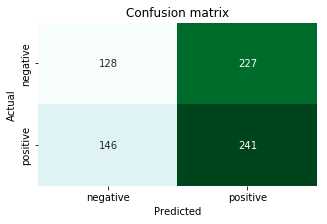

In [83]:
# Plot confusion matrix for VADER using polarity scores
print("Confusion Matrix from the VADER model using polarity scores")
plot_cm(train['target'], train['vader_polarity'])
plt.savefig('Plots/doge_pol_plot.png')

Confusion Matrix from the VADER model using compound scores


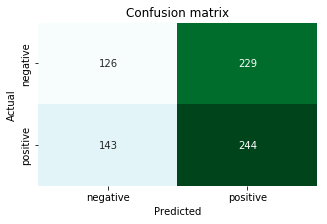

In [84]:
print("Confusion Matrix from the VADER model using compound scores")
plot_cm(train['target'], train['vader_compound'])
plt.savefig('Plots/doge_vcomp_plot.png')

Confusion Matrix from the RNN LSTM Model


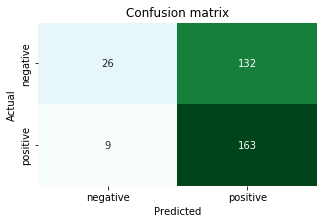

In [85]:
print("Confusion Matrix from the RNN LSTM Model")
plot_cm(y_test_rnn, y_rnn_pred)
plt.savefig('Plots/doge_lstm_plot.png')

### Accuracy Scores

In [86]:
print("Vader Accuracy - Polarity: %.2f" % (accuracy_score(train['target'], train['vader_polarity'])))
print("Vader Accuracy - Compound: %.2f" % (accuracy_score(train['target'], train['vader_compound'])))
print("RNN LSTM Accuracy %.2f" % (accuracy_score(y_test_rnn, y_rnn_pred)))

Vader Accuracy - Polarity: 0.50
Vader Accuracy - Compound: 0.50
RNN LSTM Accuracy 0.57


### AUC ROC

In [87]:
# Data for ROC Curve - VADER Compound
fpr_test_vader, tpr_test_vader, thresholds_test_vader = roc_curve(train['target'], train['vader_compound'])

In [88]:
# AUC for VADER
auc_test_vader = auc(fpr_test_vader, tpr_test_vader)
auc_test_vader = round(auc_test_vader, 4)

In [89]:
# Dataframe to plot ROC Curve for VADER
roc_df_test_vader = pd.DataFrame({"FPR Test": fpr_test_vader, "TPR Test": tpr_test_vader,})

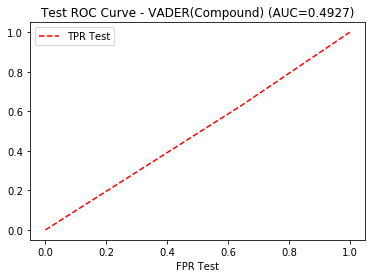

In [90]:
vcomp = roc_df_test_vader.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve - VADER(Compound) (AUC={auc_test_vader})",
)
doge_vcomp = vcomp.get_figure()
doge_vcomp.savefig('Plots/doge_vcomp.png')

In [91]:
# Data for ROC Curve - VADER Compound
fpr_test_vader, tpr_test_vader, thresholds_test_vader = roc_curve(train['target'], train['vader_polarity'])

In [92]:
# AUC for VADER
auc_test_vader = auc(fpr_test_vader, tpr_test_vader)
auc_test_vader = round(auc_test_vader, 4)

In [93]:
# Dataframe to plot ROC Curve for VADER
roc_df_test_vader = pd.DataFrame({"FPR Test": fpr_test_vader, "TPR Test": tpr_test_vader,})

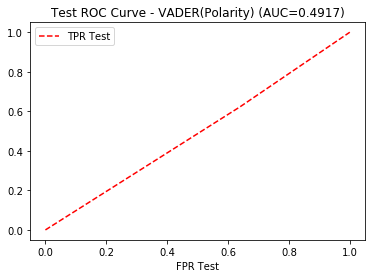

In [94]:
vpol = roc_df_test_vader.plot(
    x="FPR Test",
    y="TPR Test",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve - VADER(Polarity) (AUC={auc_test_vader})",
)
doge_vpol = vpol.get_figure()
doge_vpol.savefig('Plots/doge_vpol.png')

In [95]:
# Making predictions to feed the roc_curve module
test_predictions_rnn = model.predict(X_test_rnn, batch_size=1000)

In [96]:
# Data for ROC Curve - RNN LSTM Model
fpr_test_rnn, tpr_test_rnn, thresholds_test_rnn = roc_curve(y_test_rnn, test_predictions_rnn)

In [97]:
# AUC for the RNN LSTM Model
auc_test_rnn = auc(fpr_test_rnn, tpr_test_rnn)
auc_test_rnn = round(auc_test_rnn, 4)

In [98]:
# Dataframe to plot ROC Curve for the RNN LSTM model
roc_df_test_rnn = pd.DataFrame({"FPR Test": fpr_test_rnn, "TPR Test": tpr_test_rnn,})

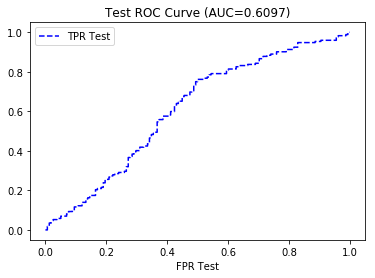

In [99]:
rnn = roc_df_test_rnn.plot(
    x="FPR Test",
    y="TPR Test",
    color="blue",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test_rnn})",
)
doge_rnn = rnn.get_figure()
doge_rnn.savefig('Plots/doge_rnn.png')